###### Importing necessary libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
import pmdarima as pm

from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

import warnings       
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')


from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


In [101]:
## Read the ‘csv’ files provided

In [102]:
df=pd.read_csv(r"D:\Data (D)\Personal files\Data science Materials\ICT Academy_Materials\TCSioN Internship\Predicting the sales of products of a retail chain\train_data.csv")

In [103]:
df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales
0,2012-01-01,74,11,others,111,Maharashtra,0
1,2012-01-01,337,11,others,111,Maharashtra,1
2,2012-01-01,423,12,others,111,Maharashtra,0
3,2012-01-01,432,12,others,111,Maharashtra,0
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0


In [104]:
price=pd.read_csv(r"D:\Data (D)\Personal files\Data science Materials\ICT Academy_Materials\TCSioN Internship\Predicting the sales of products of a retail chain\product_prices.csv")

In [105]:
price

,outlet,product_identifier,week_id,sell_price
0,111,74,49,2.94
1,111,74,50,2.94
2,111,74,51,2.94
3,111,74,52,2.94
4,111,74,53,2.94
...,...,...,...,...
58995,333,3021,162,2.08
58996,333,3021,163,2.08
58997,333,3021,164,2.08
58998,333,3021,165,2.08


In [106]:
df.shape

(395000, 7)

In [107]:
date=pd.read_csv(r"D:\Data (D)\Personal files\Data science Materials\ICT Academy_Materials\TCSioN Internship\Predicting the sales of products of a retail chain\date_to_week_id_map.csv")

In [108]:
date.head()

,date,week_id
0,2012-01-01,49
1,2012-01-02,49
2,2012-01-03,49
3,2012-01-04,49
4,2012-01-05,49


In [109]:
## merging the data sets

In [110]:
x=pd.merge(price,date, on=['week_id'], how='inner')
df=pd.merge(df,x, on=['date','product_identifier','outlet'], how='inner')
df

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88
...,...,...,...,...,...,...,...,...,...
394995,2014-02-28,2932,33,drinks_and_food,333,Kerala,2,161,2.78
394996,2014-02-28,2935,33,drinks_and_food,333,Kerala,8,161,0.20
394997,2014-02-28,3004,33,drinks_and_food,333,Kerala,0,161,2.50
394998,2014-02-28,3008,33,drinks_and_food,333,Kerala,0,161,1.98


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395000 entries, 0 to 394999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   395000 non-null  object 
 1   product_identifier     395000 non-null  int64  
 2   department_identifier  395000 non-null  int64  
 3   category_of_product    395000 non-null  object 
 4   outlet                 395000 non-null  int64  
 5   state                  395000 non-null  object 
 6   sales                  395000 non-null  int64  
 7   week_id                395000 non-null  int64  
 8   sell_price             395000 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 30.1+ MB


In [112]:
# checking the correlation between the features

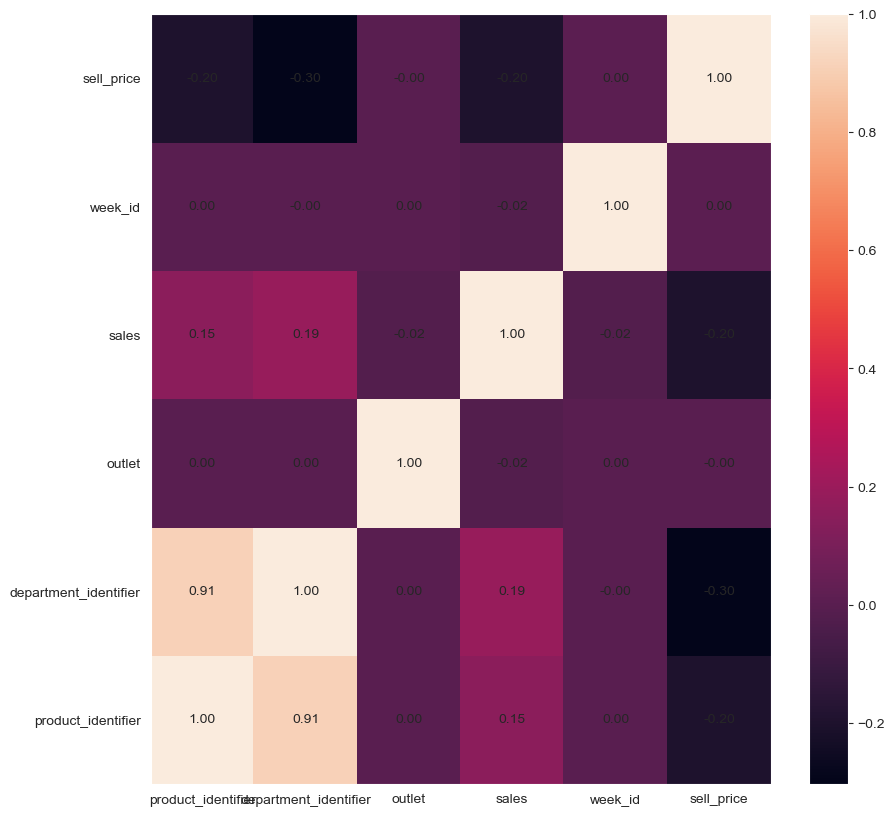

In [113]:
fig = plt.figure(figsize=(10,10))
corr = df.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)

# Add correlation values to the cells
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        plt.text(j+0.5, i+0.5, '{:.2f}'.format(corr.iloc[i,j]), ha='center', va='center')

fig.colorbar(c)
plt.show()


In [114]:
# Changing the datatypes to suitable types

In [115]:
df['date'] = pd.to_datetime(df['date'])
df['product_identifier'] = df['product_identifier'].astype('category')
df['department_identifier'] = df['department_identifier'].astype('category')
df['category_of_product'] = df['category_of_product'].astype('category')
df['outlet'] = df['outlet'].astype('category')
df['state'] = df['state'].astype('category')
df['sales'] = df['sales'].astype('int64')
df['week_id'] = df['week_id'].astype('category')

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395000 entries, 0 to 394999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   395000 non-null  datetime64[ns]
 1   product_identifier     395000 non-null  category      
 2   department_identifier  395000 non-null  category      
 3   category_of_product    395000 non-null  category      
 4   outlet                 395000 non-null  category      
 5   state                  395000 non-null  category      
 6   sales                  395000 non-null  int64         
 7   week_id                395000 non-null  category      
 8   sell_price             395000 non-null  float64       
dtypes: category(6), datetime64[ns](1), float64(1), int64(1)
memory usage: 14.3 MB


In [117]:
df.describe()

,sales,sell_price
count,395000.000000,395000.000000
mean,1.228919,4.987644
std,3.595266,3.874444
min,0.000000,0.050000
25%,0.000000,2.680000
50%,0.000000,3.980000
75%,1.000000,6.480000
max,293.000000,44.360000


In [118]:
df.nunique()

date                     790
product_identifier        50
department_identifier      6
category_of_product        3
outlet                    10
state                      3
sales                    126
week_id                  113
sell_price               107
dtype: int64

In [119]:
df.corr()['sales']

sales         1.000000
sell_price   -0.198098
Name: sales, dtype: float64

In [120]:
#### other Features have no correlation with the sales feature.

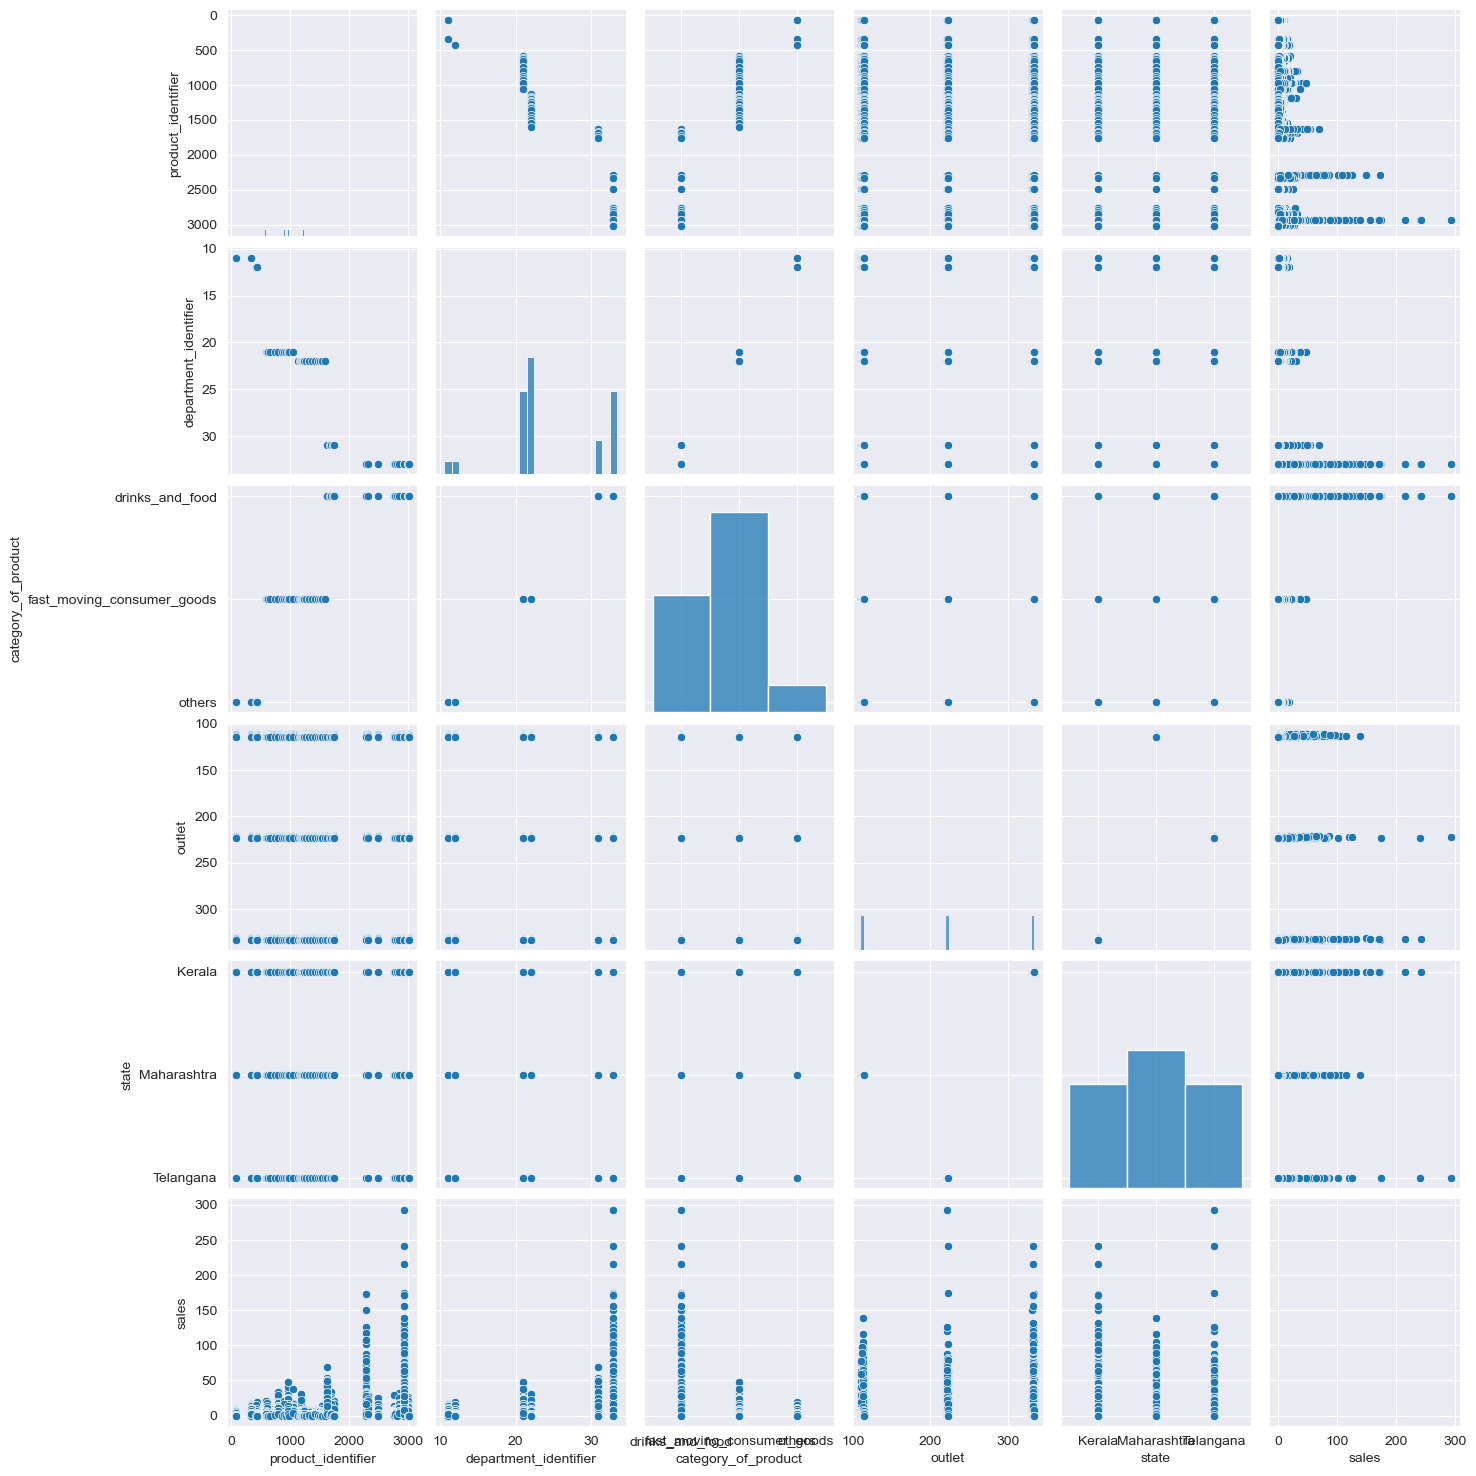

In [121]:
sns.pairplot(df, vars=['product_identifier','department_identifier','category_of_product','outlet','state','sales'])

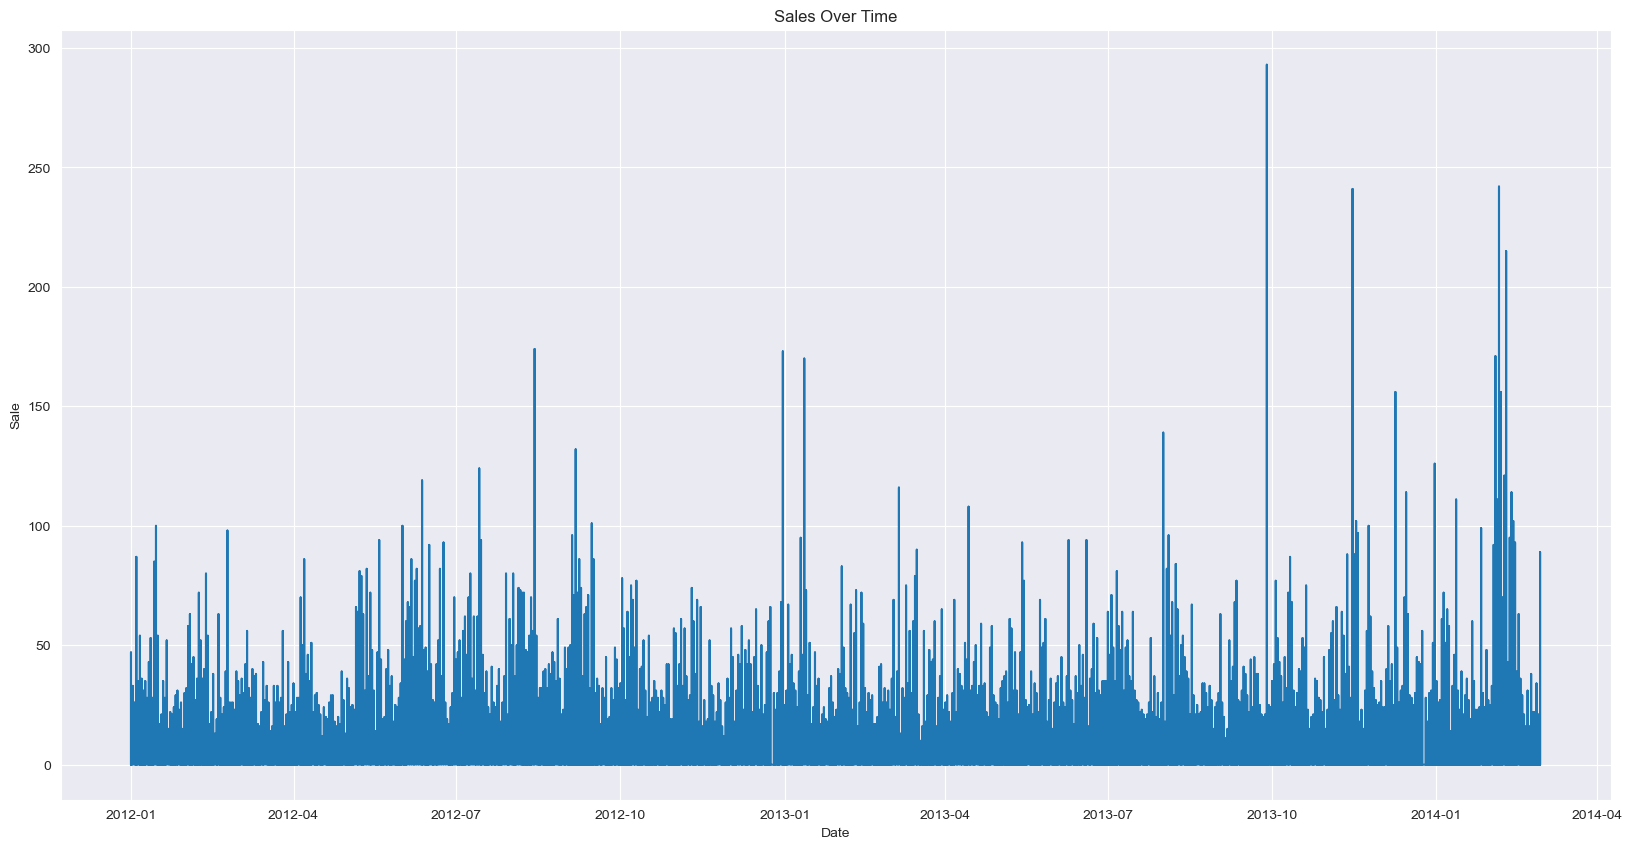

In [122]:
plt.figure(figsize=(20,10))
plt.plot(df['date'],df['sales'])
plt.xlabel('Date')
plt.ylabel('Sale')
plt.title('Sales Over Time')
plt.show()

## Indexing time series data

In [123]:
df = df.set_index(['date'])

In [124]:
df.index.min(), df.index.max()

(Timestamp('2012-01-01 00:00:00'), Timestamp('2014-02-28 00:00:00'))

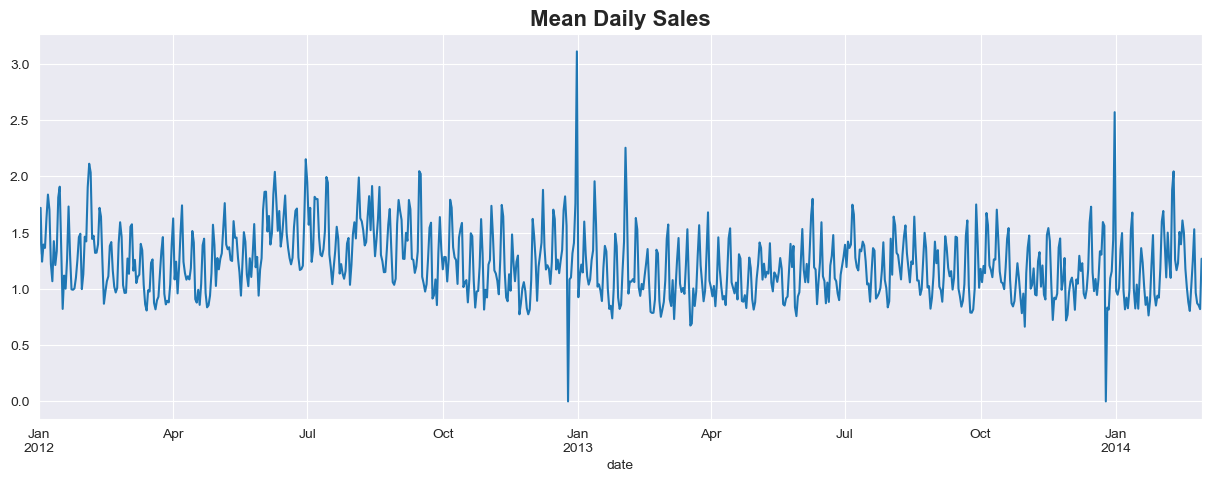

In [125]:
#observing mean daily sales of drinks_and_food
df['sales'].resample('D').mean().plot(figsize = (15,5))
plt.title('Mean Daily Sales', fontsize=16, fontweight='bold')
plt.show()

###### The drop in sales by the end of the year is due the shop closing on 25th Dec

## Resampling the data 

date
2012-01-01    1.328903
2012-02-01    1.341034
2012-03-01    1.116774
2012-04-01    1.178533
2012-05-01    1.298194
2012-06-01    1.562867
2012-07-01    1.420000
2012-08-01    1.487742
2012-09-01    1.366733
2012-10-01    1.222968
2012-11-01    1.141800
2012-12-01    1.374129
2013-01-01    1.147032
2013-02-01    1.135143
2013-03-01    1.110645
2013-04-01    1.055267
2013-05-01    1.104323
2013-06-01    1.193867
2013-07-01    1.211935
2013-08-01    1.242645
2013-09-01    1.142333
2013-10-01    1.155613
2013-11-01    1.111933
2013-12-01    1.164516
2014-01-01    1.062581
2014-02-01    1.274429
Freq: MS, Name: sales, dtype: float64


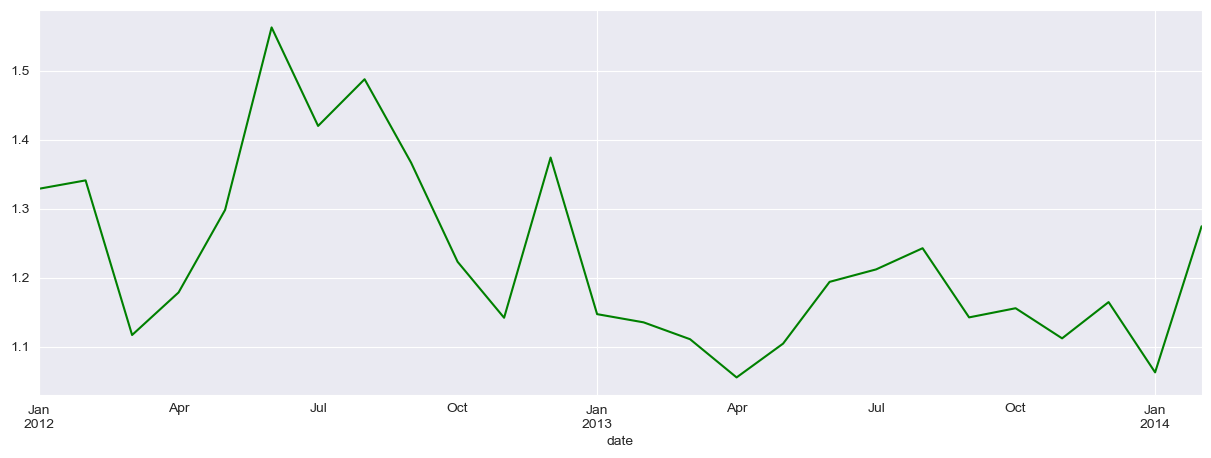

In [126]:
#monthly mean sales begin
mean_monthlysales = df.resample(rule='MS').mean()['sales']
print(mean_monthlysales)
sns.set_style('darkgrid')
mean_monthlysales.plot(figsize=(15,5),c='green')
plt.show()

## Note:
#### Mean monthly sales is maximum in month march of year 2012.
#### Also on month June 2012, Aug 2012, Dec 2012, Feb 2012 shows higher sales.
#### There is a huge dip in the graph during April 2013 which shows least sales.

In [127]:
df.head()

,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
date,,,,,,,,
2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88


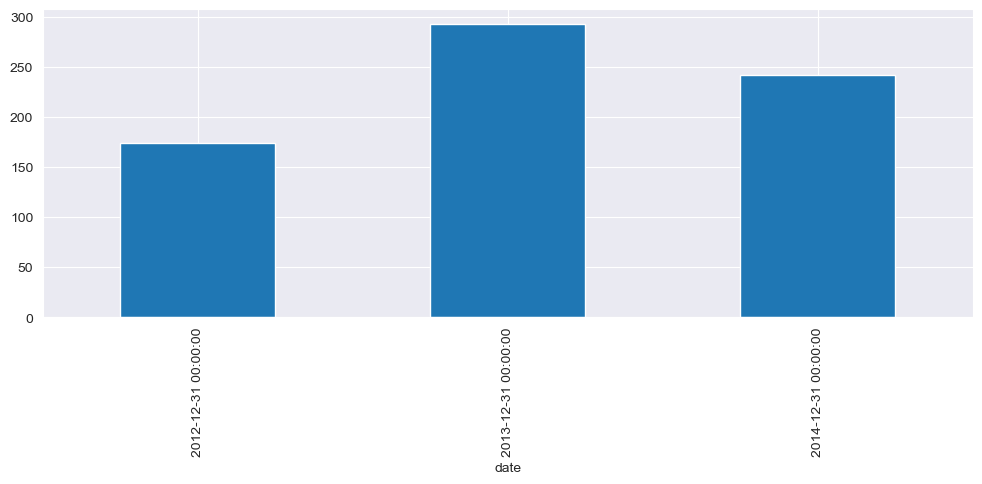

In [128]:
df.resample(rule='A').max()['sales'].plot(kind='bar', figsize = (12,4))
plt.show()

In [129]:
df.category_of_product.unique()

['others', 'fast_moving_consumer_goods', 'drinks_and_food']
Categories (3, object): ['drinks_and_food', 'fast_moving_consumer_goods', 'others']

In [130]:
#checking for unique values in columns
{column: len(df[column].unique()) for column in df.columns}

{'product_identifier': 50,
 'department_identifier': 6,
 'category_of_product': 3,
 'outlet': 10,
 'state': 3,
 'sales': 126,
 'week_id': 113,
 'sell_price': 107}

In [131]:
df = df.copy()
#dropping unnecessary columns    
col = ['product_identifier','department_identifier','outlet','state','week_id','sell_price']
df.drop(col,axis=1, inplace=True)

## drinks_and_food

In [132]:
#selecting rows where category is drinks_and_food
drinks_and_food_data = df.loc[df['category_of_product'] == 'drinks_and_food']
drinks_and_food_data

,category_of_product,sales
date,,
2012-01-01,drinks_and_food,9
2012-01-01,drinks_and_food,2
2012-01-01,drinks_and_food,1
2012-01-01,drinks_and_food,0
2012-01-01,drinks_and_food,1
...,...,...
2014-02-28,drinks_and_food,2
2014-02-28,drinks_and_food,8
2014-02-28,drinks_and_food,0


In [133]:
drinks_and_food_data.drop('category_of_product',axis=1, inplace=True)

In [134]:
drinks_and_food_data.head()

,sales
date,
2012-01-01,9
2012-01-01,2
2012-01-01,1
2012-01-01,0
2012-01-01,1


In [135]:
drinks_and_food_data.describe()

,sales
count,134300.000000
mean,2.338057
std,5.648824
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,293.000000


In [136]:
#sorting by date
drinks_and_food_data = drinks_and_food_data.sort_values('date')
drinks_and_food_data

,sales
date,
2012-01-01,9
2012-01-01,2
2012-01-01,0
2012-01-01,0
2012-01-01,0
...,...
2014-02-28,1
2014-02-28,0
2014-02-28,1


In [137]:
#taking monthly mean sales of category drinks_and_food
y_drinks_and_food = drinks_and_food_data['sales'].resample('D').mean()

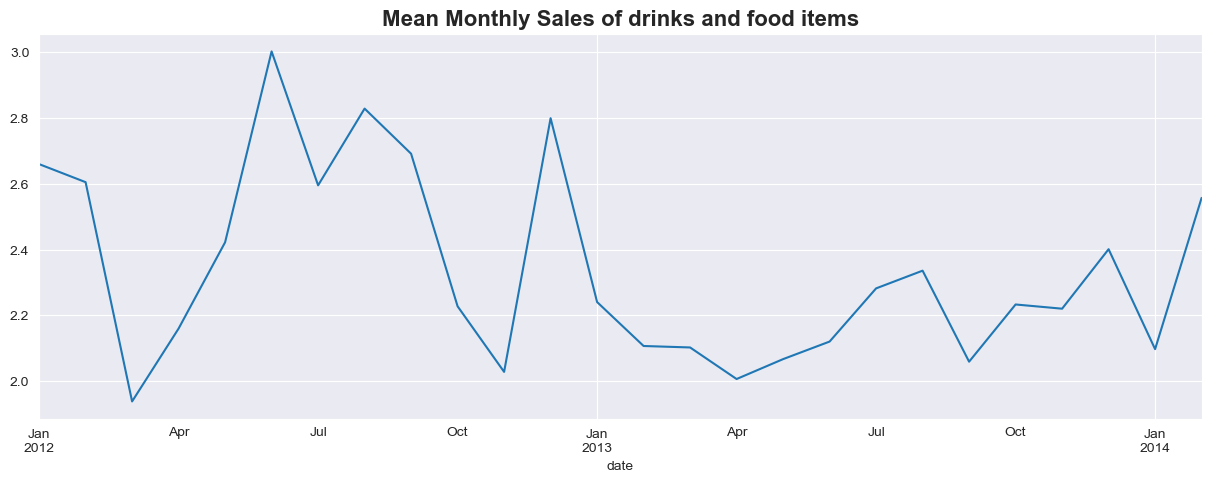

In [138]:
#observing mean monthly sales of drinks_and_food
drinks_and_food_data['sales'].resample('MS').mean().plot(figsize = (15,5))
plt.title('Mean Monthly Sales of drinks and food items', fontsize=16, fontweight='bold')
plt.show()

###### Note: average sales is maximum at June 2012

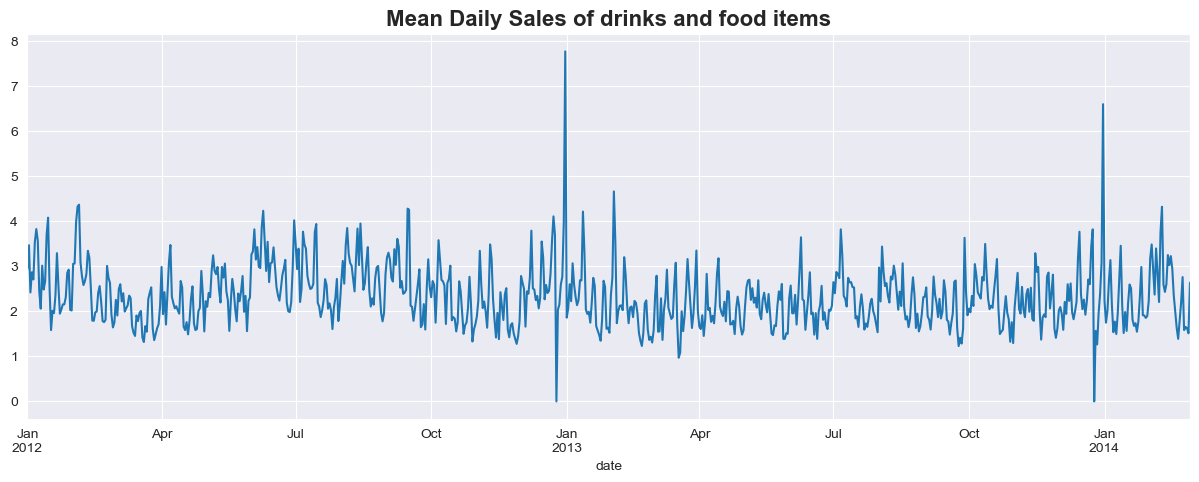

In [139]:
#observing mean daily sales of drinks_and_food
drinks_and_food_data['sales'].resample('D').mean().plot(figsize = (15,5))
plt.title('Mean Daily Sales of drinks and food items', fontsize=16, fontweight='bold')
plt.show()

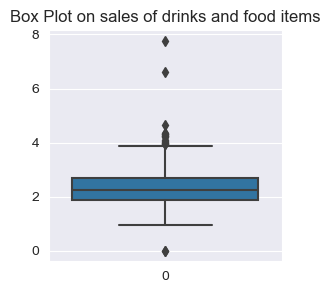

In [140]:
#checking for outliers
fig = plt.figure(figsize=(3,3))
sns.boxplot(y_drinks_and_food).set_title('Box Plot on sales of drinks and food items')
plt.show()

###### There is one outlier in the drinks and food data.

## fast moving consumer goods

In [141]:
fast_moving_consumer_goods_data = df.loc[df['category_of_product'] == 'fast_moving_consumer_goods']
fast_moving_consumer_goods_data

,category_of_product,sales
date,,
2012-01-01,fast_moving_consumer_goods,0
2012-01-01,fast_moving_consumer_goods,0
2012-01-01,fast_moving_consumer_goods,0
2012-01-01,fast_moving_consumer_goods,0
2012-01-01,fast_moving_consumer_goods,0
...,...,...
2014-02-28,fast_moving_consumer_goods,1
2014-02-28,fast_moving_consumer_goods,0
2014-02-28,fast_moving_consumer_goods,0


In [142]:
fast_moving_consumer_goods_data.drop('category_of_product',axis=1, inplace=True)

In [143]:
fast_moving_consumer_goods_data = fast_moving_consumer_goods_data.sort_values('date')
fast_moving_consumer_goods_data.head()

,sales
date,
2012-01-01,0
2012-01-01,0
2012-01-01,0
2012-01-01,0
2012-01-01,1


In [144]:
fast_moving_consumer_goods_data.describe()

,sales
count,229100.000000
mean,0.657390
std,1.505019
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,48.000000


In [145]:
y_fast_moving_consumer_goods = fast_moving_consumer_goods_data['sales'].resample('D').mean()

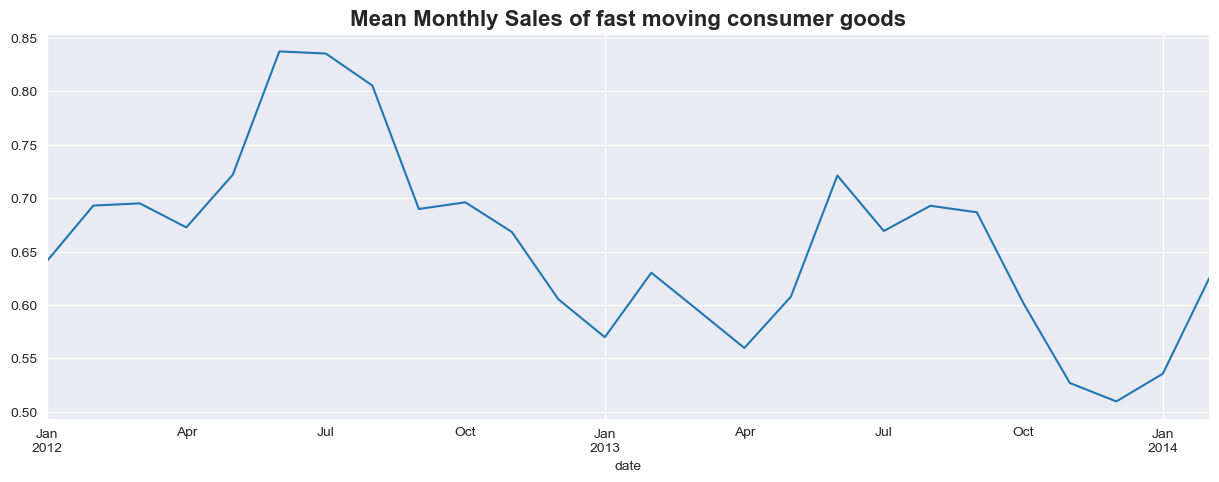

In [146]:
fast_moving_consumer_goods_data['sales'].resample('MS').mean().plot(figsize = (15,5))
plt.title('Mean Monthly Sales of fast moving consumer goods', fontsize=16, fontweight='bold')
plt.show()

###### Sales for office supplies shows increase at start of year between april to july and minimum at end of year.

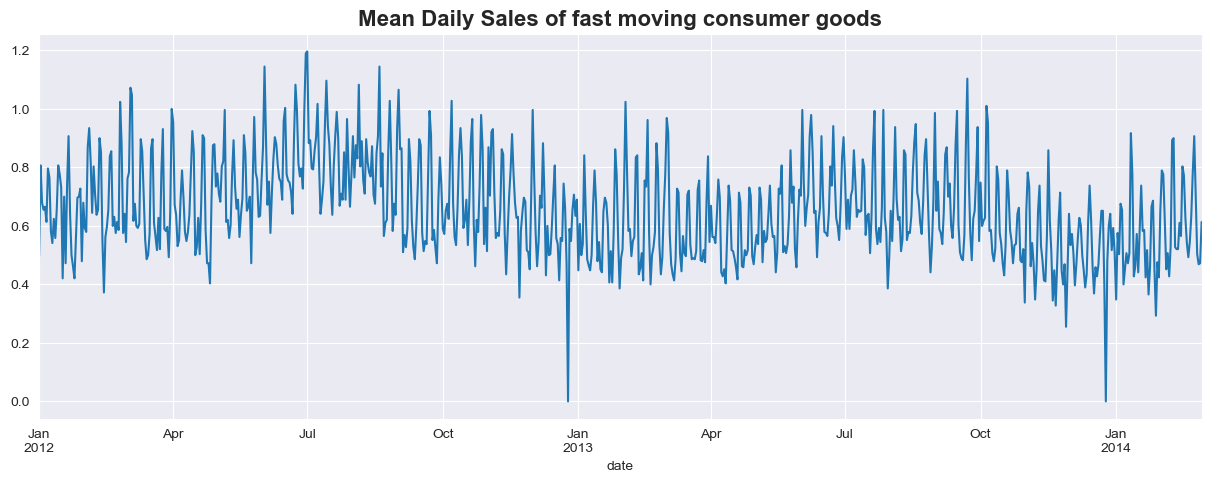

In [147]:
#observing mean daily sales of drinks_and_food
fast_moving_consumer_goods_data['sales'].resample('D').mean().plot(figsize = (15,5))
plt.title('Mean Daily Sales of fast moving consumer goods', fontsize=16, fontweight='bold')
plt.show()

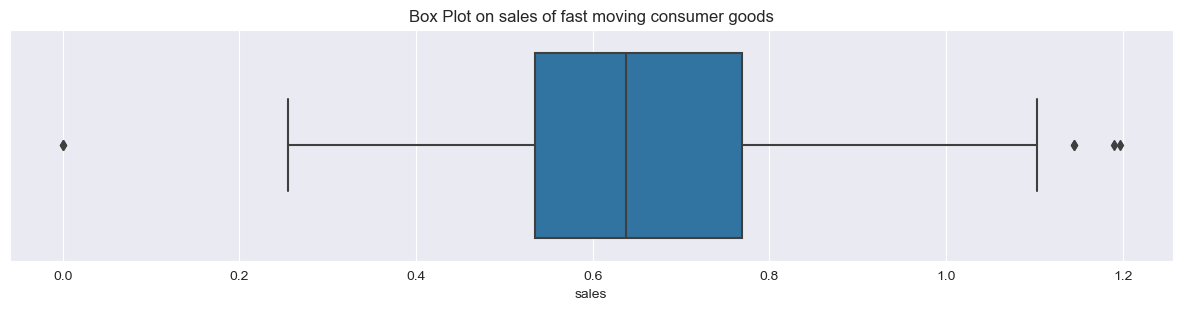

In [148]:
fig = plt.figure(figsize=(15,3))
sns.boxplot(x=y_fast_moving_consumer_goods).set_title('Box Plot on sales of fast moving consumer goods')
plt.show()

###### There are two outliers in the office items data.

## others  items

In [149]:
other_item_data = df.loc[df['category_of_product'] == 'others']
other_item_data

,category_of_product,sales
date,,
2012-01-01,others,0
2012-01-01,others,1
2012-01-01,others,0
2012-01-01,others,0
2012-01-01,others,0
...,...,...
2014-02-28,others,0
2014-02-28,others,0
2014-02-28,others,2


In [150]:
other_item_data.drop('category_of_product',axis=1, inplace=True)

In [151]:
other_item_data = other_item_data.sort_values('date')
other_item_data.head()

,sales
date,
2012-01-01,0
2012-01-01,0
2012-01-01,0
2012-01-01,0
2012-01-01,0


In [152]:
other_item_data.describe()

,sales
count,31600.000000
mean,0.658671
std,1.271748
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,19.000000


In [153]:
y_other_item = other_item_data['sales'].resample('D').mean()

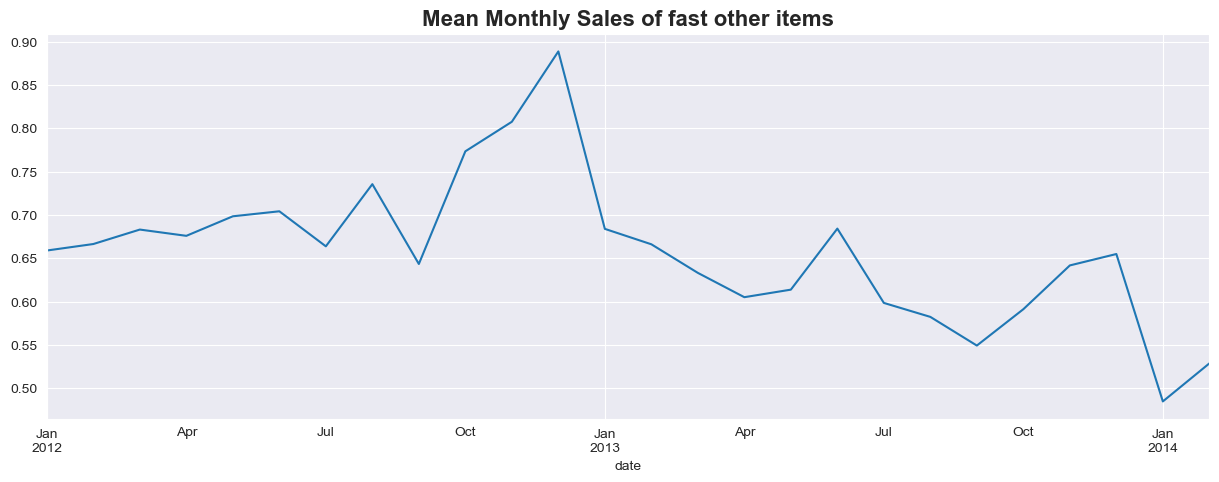

In [154]:
other_item_data['sales'].resample('MS').mean().plot(figsize = (15,5))
plt.title('Mean Monthly Sales of fast other items', fontsize=16, fontweight='bold')
plt.show()

###### Sales for other items shows maximum sales in Dec 2012

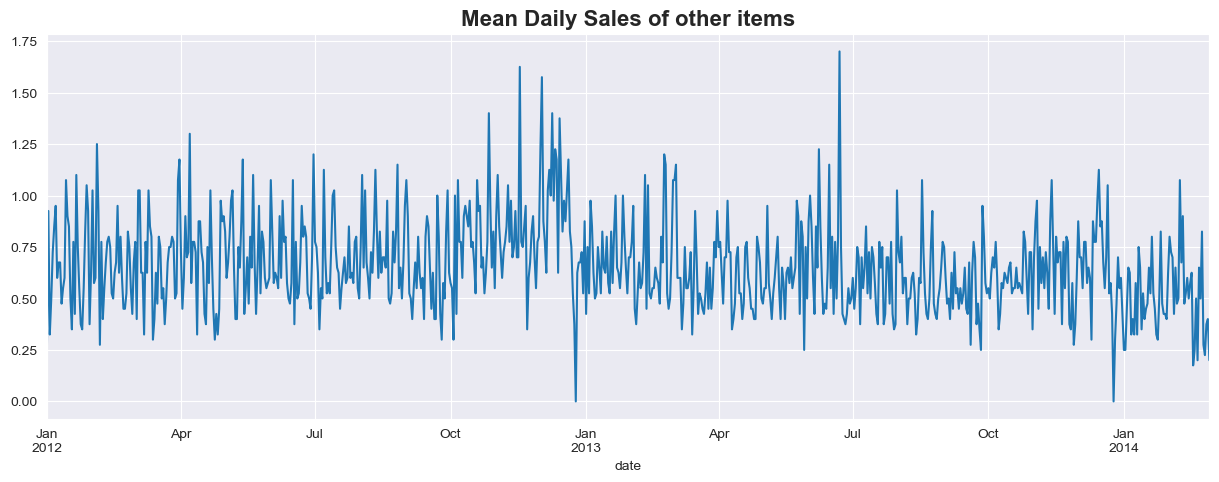

In [155]:
#observing mean daily sales of other item
other_item_data['sales'].resample('D').mean().plot(figsize = (15,5))
plt.title('Mean Daily Sales of other items', fontsize=16, fontweight='bold')
plt.show()

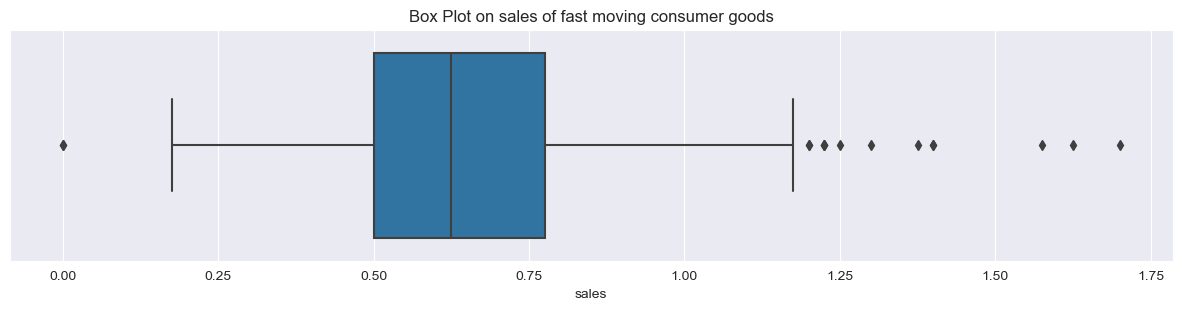

In [156]:
fig = plt.figure(figsize=(15,3))
sns.boxplot(x=y_other_item).set_title('Box Plot on sales of fast moving consumer goods')
plt.show()

###### There are three outliers in the other items data.

## Seasonal Decomposition of each category

In [157]:
df.category_of_product.unique()

['others', 'fast_moving_consumer_goods', 'drinks_and_food']
Categories (3, object): ['drinks_and_food', 'fast_moving_consumer_goods', 'others']

#### Drinks and food items

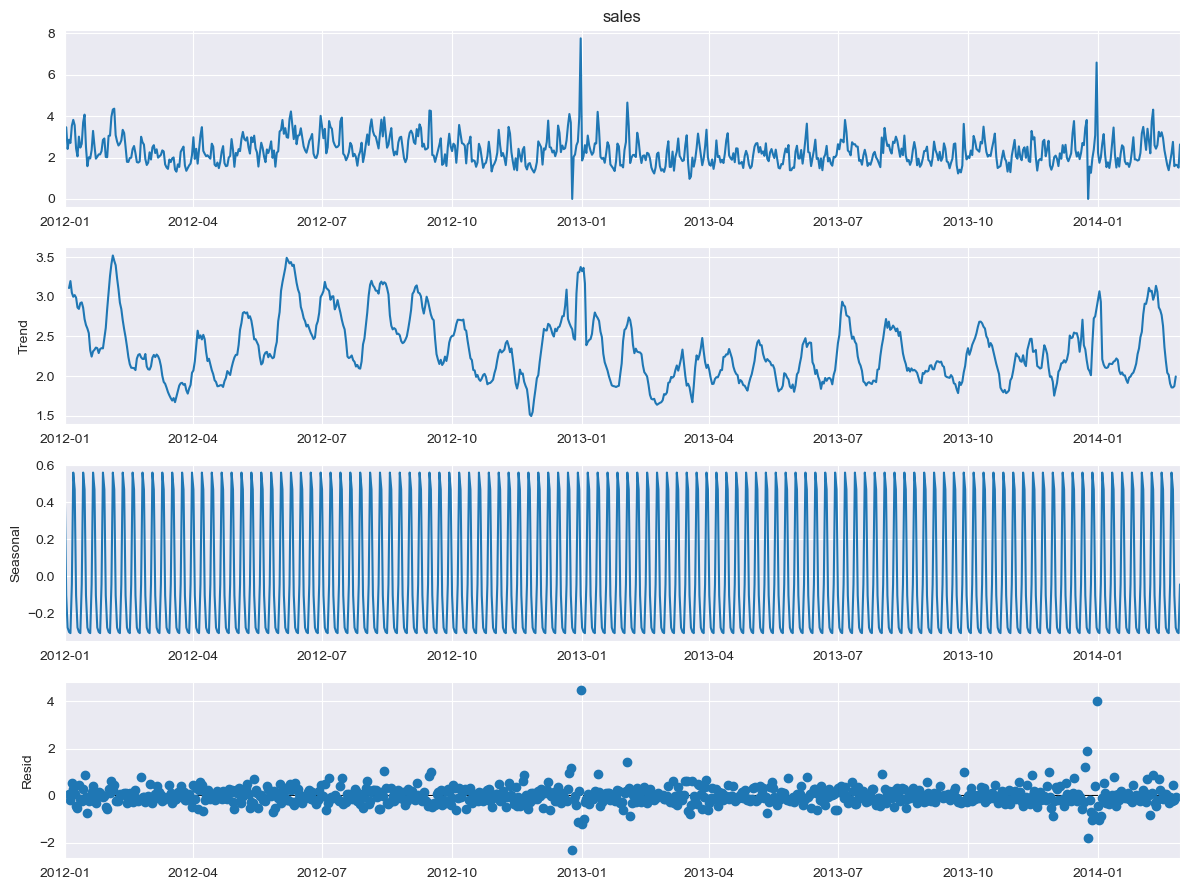

In [158]:
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y_drinks_and_food, model='additive')
fig = decomposition.plot()
plt.show()

###### Trend graph shows a continuously fluctuating trend with a high and low sales values in every month. 

#### Fast moving consumer goods

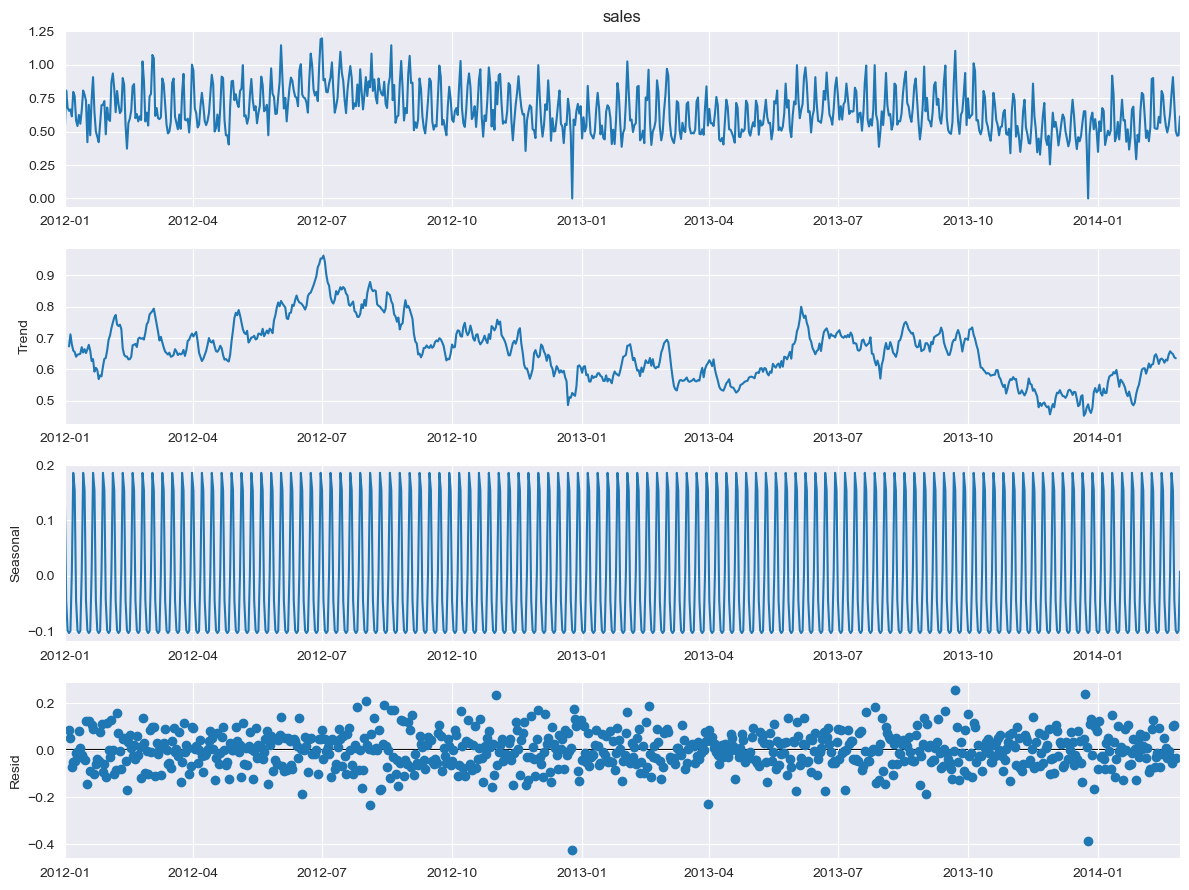

In [159]:
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y_fast_moving_consumer_goods, model='additive')
fig = decomposition.plot()
plt.show()

###### The trend graph shows a gradual decrease in sales for nearly a year from July 2012 to July 2013

#### Other items

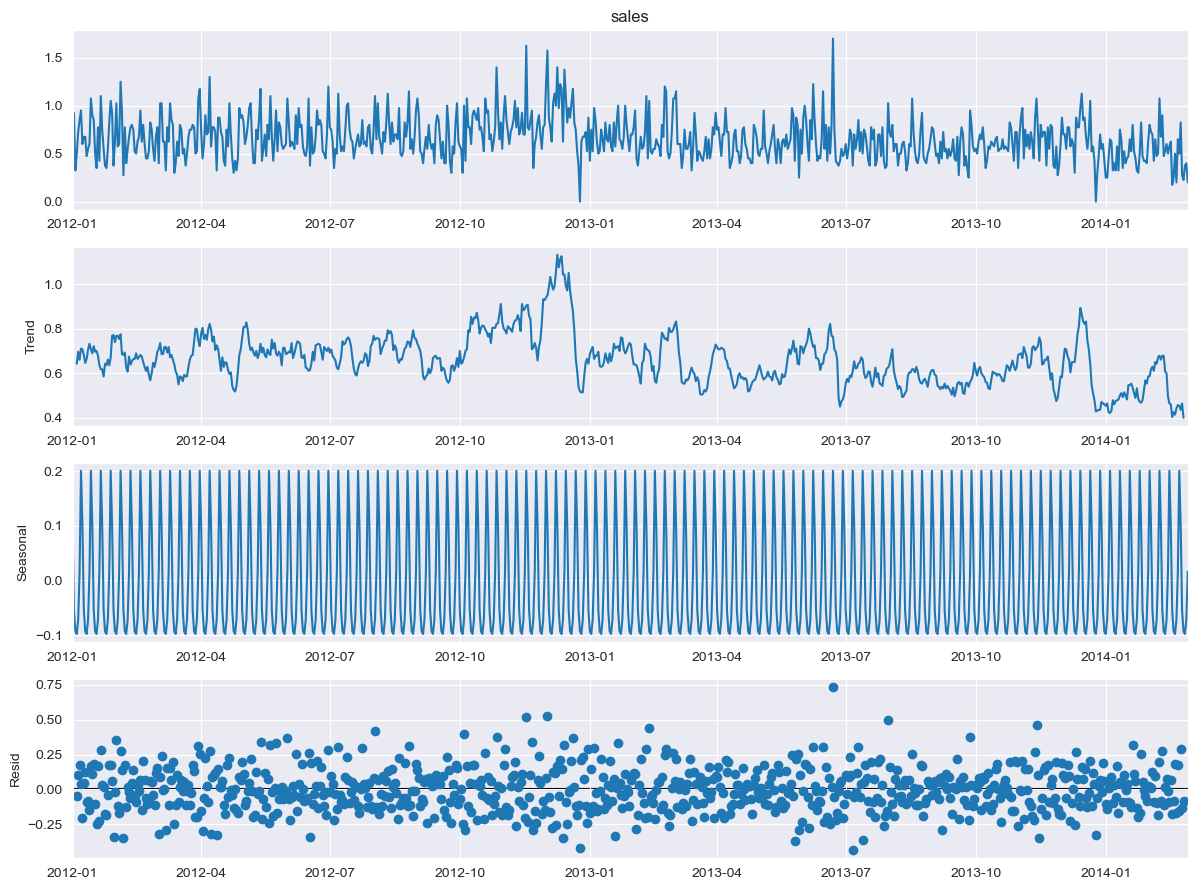

In [160]:
rcParams['figure.figsize'] = 12, 9
decomposition = sm.tsa.seasonal_decompose(y_other_item, model='additive')
fig = decomposition.plot()
plt.show()

###### The trend graph shows a gradual decrease in sales for nearly a year from July 2012 to July 2013

## Test for stationarity

In [161]:
#Augmented dickey-fuller test
#H0 : data is non stationary (unit root =1)
#H1 : data is stationery (unit root <1)

def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF test statistic', 'p-value', 'Number of observations used', '#lags used','Critical Value']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [162]:
adfuller_test(y_drinks_and_food)

ADF test statistic : -4.115952768903988
p-value : 0.0009113614721863807
Number of observations used : 20
#lags used : 769
Critical Value : {'1%': -3.438882201132452, '5%': -2.865305765357574, '10%': -2.568775270215655}
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [163]:
adfuller_test(y_fast_moving_consumer_goods)

ADF test statistic : -1.7916674105829045
p-value : 0.3846063698596694
Number of observations used : 20
#lags used : 769
Critical Value : {'1%': -3.438882201132452, '5%': -2.865305765357574, '10%': -2.568775270215655}
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [164]:
adfuller_test(y_other_item)

ADF test statistic : -3.0573403339234013
p-value : 0.029875540531744165
Number of observations used : 21
#lags used : 768
Critical Value : {'1%': -3.4388933482333464, '5%': -2.8653106782623574, '10%': -2.5687778874376086}
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


##### Findings:

The p-value<0.05 for drinks_and_food, so rejecting null hypothesis and assume a stationery datasets.

The p-value>0.05 for fast_moving_consumer_goods, so null hypothesis is true. and assume a non-stationery datasets.

The p-value>0.05 for other_items, so null hypothesis and assume a non-stationery datasets.

## Converting non-ststionary series into stationary

In [165]:
# Compute the first-order difference
y_fast_moving_consumer_goods = y_fast_moving_consumer_goods.diff().dropna()

y_other_item = y_other_item.diff().dropna()

Checking whether the series is stationary or not after differencing

adfuller_test(y_other_item)

In [166]:
adfuller_test(y_fast_moving_consumer_goods)

ADF test statistic : -8.527284620579819
p-value : 1.0607463059549147e-13
Number of observations used : 21
#lags used : 767
Critical Value : {'1%': -3.4389045244994096, '5%': -2.8653156040031176, '10%': -2.5687805115003}
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


## Autocorrelation and Partial Autocorrelation plots

ACF measures correlation between the time series with a lagged version itself and PACF similiar to ACF but after eliminating the variations.

In [167]:
df.category_of_product.unique()

['others', 'fast_moving_consumer_goods', 'drinks_and_food']
Categories (3, object): ['drinks_and_food', 'fast_moving_consumer_goods', 'others']

###### drinks and food items

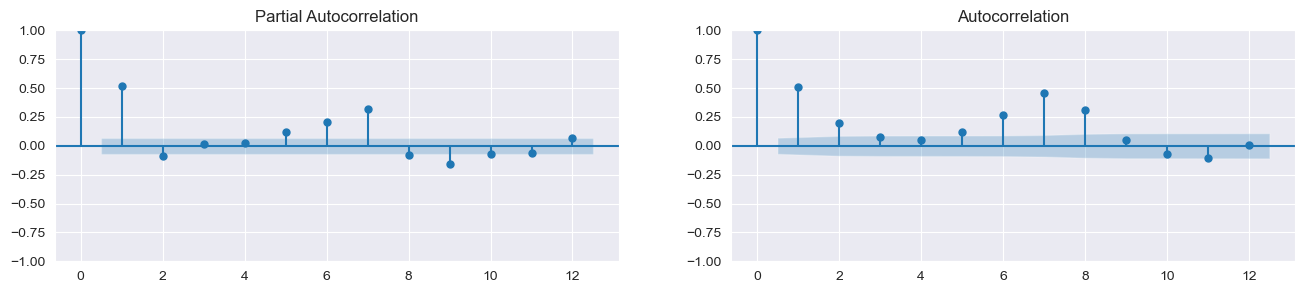

In [168]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_drinks_and_food,lags=12,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_drinks_and_food, lags=12,ax=axes[1])
plt.show()

###### Fast moving consumer goods

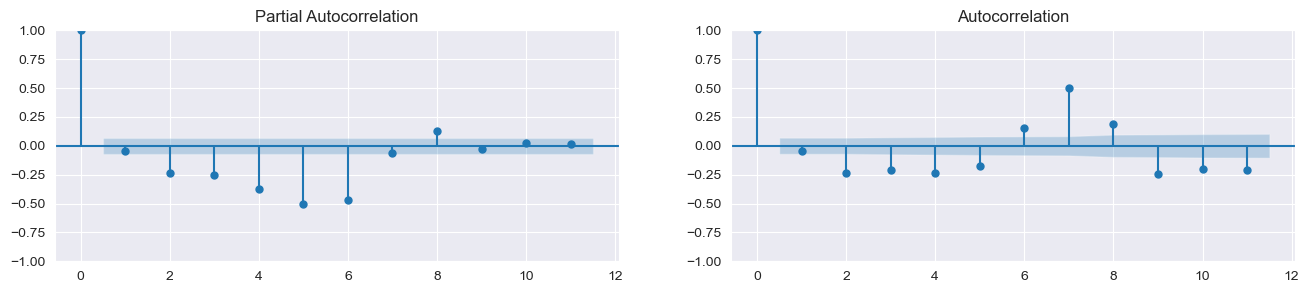

In [169]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_fast_moving_consumer_goods,lags=11,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_fast_moving_consumer_goods, lags=11,ax=axes[1])
plt.show()

###### Other item

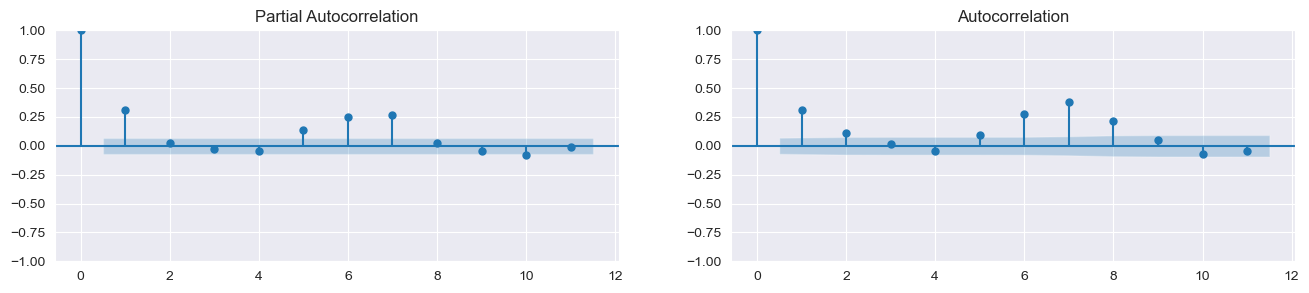

In [170]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
sm.graphics.tsa.plot_pacf(y_other_item,lags=11,method="ols",ax=axes[0])
sm.graphics.tsa.plot_acf(y_other_item, lags=11,ax=axes[1])
plt.show()

## Drinks and Food

### Using  Auto ARIMA for choosing best parameters

In [171]:
stepwise_fit = auto_arima(y_drinks_and_food, start_p=1, start_q=1,
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=12, max_q=11,  # maximum p and q
                      m=12,              # frequency of series
                      d=None,            # let model determine 'd'
                      seasonal=True,     #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1399.923, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1641.581, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1403.160, Time=0.98 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1428.128, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3650.388, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1398.356, Time=0.23 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1400.003, Time=1.42 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1426.179, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1402.062, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1400.347, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1400.348, Time=0.63 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=1402.670, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1398.428, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  790
Model:             SARIMAX(1, 0, 3)x(0, 0, [1, 2], 12)   Log Likelihood                -678.326
Date:                                 Fri, 19 May 2023   AIC                           1372.651
Time:                                         21:20:30   BIC                           1410.028
Sample:                                              0   HQIC                          1387.018
                                                 - 790                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0669      0.043      1.563      0.118      -0.017       0.151
ar.L1          0.9714      0.018     53.200      0.000       0.936       1.007
ma.L1         -0.4726      0.027    -17.817      0.000      -0.525      -0.421
ma.L2         -0.3134      0.045     -6.968      0.000      -0.402      -0.225
ma.L3         -0.0779      0.039     -1.998      0.046      -0.154      -0.001
ma.S.L12      -0.0541      0.027     -2.003      0.045      -0.107      -0.001
ma.S.L24      -0.1298      0.044     -2.980      0.003      -0.215      -0.044
sigma2         0.3255      0.007     45.169      0.000       0.311       0.340
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3799.81
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.95
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [172]:
#splitting into test and train
train1 = y_drinks_and_food.loc['2012-01-01':'2013-12-31']
test1 = y_drinks_and_food.loc['2013-12-31':'2014-01-31']

In [173]:
train1.shape

(731,)

In [174]:
test1.shape

(32,)

In [175]:
train1

date
2012-01-01    2.947059
2012-01-02    3.464706
2012-01-03    2.417647
2012-01-04    2.864706
2012-01-05    2.705882
                ...   
2013-12-27    1.264706
2013-12-28    1.958824
2013-12-29    2.388235
2013-12-30    3.082353
2013-12-31    6.594118
Freq: D, Name: sales, Length: 731, dtype: float64

In [176]:
model=SARIMAX(train1,order=(1,0,3),seasonal_order=(0,0,2,12))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   sales   No. Observations:                  731
Model:             SARIMAX(1, 0, 3)x(0, 0, [1, 2], 12)   Log Likelihood                -627.580
Date:                                 Fri, 19 May 2023   AIC                           1269.160
Time:                                         21:20:35   BIC                           1301.321
Sample:                                     01-01-2012   HQIC                          1281.567
                                          - 12-31-2013                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.000   2047.494      0.000       0.999       1.001
ma.L1         -0.4694      0.023    -20.018      0.000      -0.515      -0.423
ma.L2         -0.3188      0.044     -7.256      0.000      -0.405      -0.233
ma.L3         -0.1084      0.039     -2.796      0.005      -0.184      -0.032
ma.S.L12      -0.0951      0.029     -3.295      0.001      -0.152      -0.039
ma.S.L24      -0.1213      0.047     -2.559      0.010      -0.214      -0.028
sigma2         0.3237      0.007     47.577      0.000       0.310       0.337
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4072.88
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.93
Prob(H) (two-sided):                  0.03   Kurtosis:                        14.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [177]:
start=len(train1)
end=len(train1)+len(test1)-1
pred=model.predict(start=start,end=end,type='levels')
print(pred)

2014-01-01    4.462481
2014-01-02    2.974241
2014-01-03    2.674284
2014-01-04    2.617443
2014-01-05    2.567751
2014-01-06    2.907074
2014-01-07    2.621474
2014-01-08    2.574142
2014-01-09    2.697821
2014-01-10    2.670075
2014-01-11    2.579394
2014-01-12    2.287990
2014-01-13    2.453884
2014-01-14    2.507521
2014-01-15    2.590349
2014-01-16    2.492625
2014-01-17    2.442805
2014-01-18    2.899690
2014-01-19    2.696067
2014-01-20    2.726558
2014-01-21    2.663504
2014-01-22    2.603212
2014-01-23    2.519053
2014-01-24    2.089210
2014-01-25    2.349033
2014-01-26    2.512816
2014-01-27    2.564906
2014-01-28    2.564516
2014-01-29    2.564127
2014-01-30    2.563737
2014-01-31    2.563348
2014-02-01    2.562959
Freq: D, Name: predicted_mean, dtype: float64


<Axes: xlabel='date'>

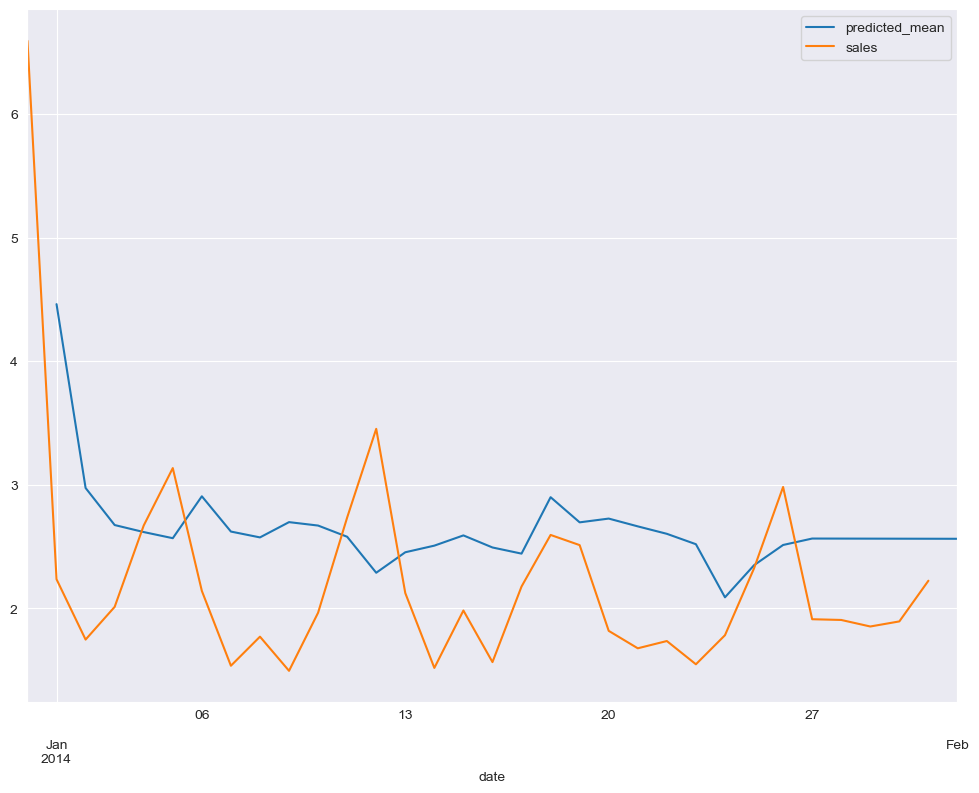

In [178]:
pred.plot(legend=True)
test1.plot(legend=True)

In [179]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rsme=sqrt(mean_squared_error(pred,test1))
print(rsme)

0.7777836463429518


### 
## Forecasting the sales of drinks and food items for the month of february 2014
### 

In [180]:
model2=SARIMAX(y_drinks_and_food,order=(1,0,3),seasonal_order=(0,0,2,12))
model2=model2.fit()
y_drinks_and_food.tail()

date
2014-02-24    1.582353
2014-02-25    1.652941
2014-02-26    1.623529
2014-02-27    1.511765
2014-02-28    2.635294
Freq: D, Name: sales, dtype: float64

In [181]:
index_future_dates=pd.date_range(start='2014-01-31',end='2014-02-28')
pred=model2.predict(start=len(y_drinks_and_food),end=len(y_drinks_and_food)+28,type='levels').rename('ARIMA Predictions')
pred.index=index_future_dates

<Axes: >

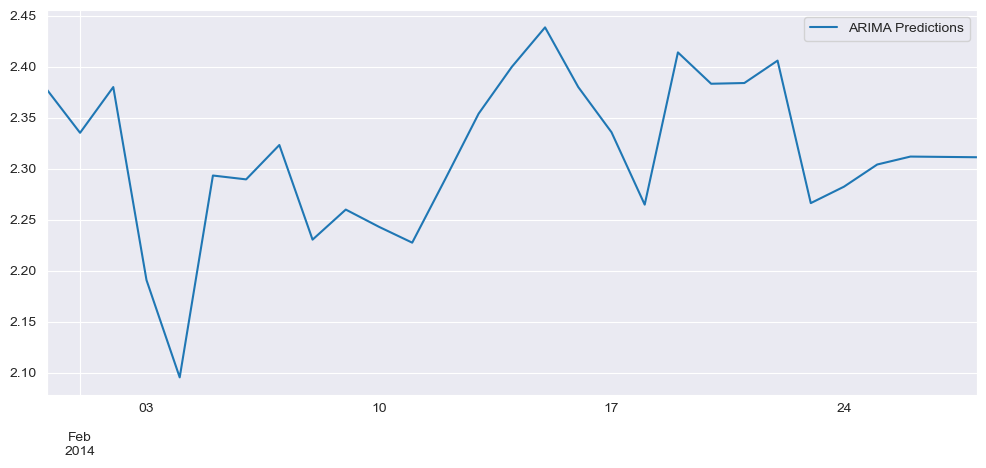

In [182]:
pred.plot(figsize=(12,5),legend=True)

## Fast Moving Consumer Goods

#### Using Auto ARIMA for choosing best parameters

In [183]:
stepwise_fit = auto_arima(y_fast_moving_consumer_goods, start_p=1, start_q=1,
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=12, max_q=11,  # maximum p and q
                      m=12,              # frequency of series
                      d=None,            # let model determine 'd'
                      seasonal=True,     #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-953.534, Time=2.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-655.956, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-696.988, Time=0.53 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-838.499, Time=1.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-657.955, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-893.568, Time=0.66 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-973.928, Time=11.25 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-990.184, Time=12.59 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-1221.650, Time=13.04 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-1048.640, Time=14.77 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=14.47 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=11.57 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=-1181.031, Time=15.61 sec
 ARIMA(1,0,2)(2,0,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  789
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 626.701
Date:                            Fri, 19 May 2023   AIC                          -1233.402
Time:                                    21:25:30   BIC                          -1186.694
Sample:                                         0   HQIC                         -1215.447
                                            - 789                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0006      0.001     -0.560      0.575      -0.003       0.002
ar.L1         -0.4723      0.324     -1.457      0.145      -1.108       0.163
ar.L2         -0.0171      0.065     -0.265      0.791      -0.144       0.109
ma.L1         -0.3394      0.321     -1.057      0.290      -0.969       0.290
ma.L2         -0.5236      0.299     -1.753      0.080      -1.109       0.062
ar.S.L12      -0.4339      0.018    -24.081      0.000      -0.469      -0.399
ar.S.L24      -0.9399      0.017    -55.937      0.000      -0.973      -0.907
ma.S.L12       0.3066      0.039      7.812      0.000       0.230       0.384
ma.S.L24       0.7850      0.041     19.216      0.000       0.705       0.865
sigma2         0.0115      0.001     18.547      0.000       0.010       0.013
===================================================================================
Ljung-Box (L1) (Q):                   6.17   Jarque-Bera (JB):                 9.02
Prob(Q):                              0.01   Prob(JB):                         0.01
Heteroskedasticity (H):               0.77   Skew:                             0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [184]:
#splitting into test and train
train2 = y_fast_moving_consumer_goods.loc['2012-01-01':'2013-12-31']
test2 = y_fast_moving_consumer_goods.loc['2013-12-31':'2014-01-31']

In [185]:
train2.shape

(730,)

In [186]:
test2.shape

(32,)

In [187]:
train2

date
2012-01-02    0.310345
2012-01-03   -0.127586
2012-01-04   -0.024138
2012-01-05    0.010345
2012-01-06   -0.051724
                ...   
2013-12-27    0.120690
2013-12-28    0.041379
2013-12-29   -0.124138
2013-12-30    0.075862
2013-12-31   -0.086207
Freq: D, Name: sales, Length: 730, dtype: float64

In [188]:
from statsmodels.tsa.arima_model import ARIMA
model=SARIMAX(train2,order=(2,0,2),seasonal_order=(2,0,2,12))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  730
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood                 605.104
Date:                            Fri, 19 May 2023   AIC                          -1192.207
Time:                                    21:25:38   BIC                          -1150.870
Sample:                                01-02-2012   HQIC                         -1176.259
                                     - 12-31-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1133      0.287      0.394      0.693      -0.450       0.676
ar.L2         -0.1469      0.059     -2.473      0.013      -0.263      -0.030
ma.L1         -0.8881      0.288     -3.078      0.002      -1.454      -0.323
ma.L2          0.0019      0.265      0.007      0.994      -0.518       0.521
ar.S.L12      -0.4491      0.005    -89.935      0.000      -0.459      -0.439
ar.S.L24      -0.9984      0.003   -346.190      0.000      -1.004      -0.993
ma.S.L12       0.4001      0.032     12.656      0.000       0.338       0.462
ma.S.L24       0.9847      0.122      8.045      0.000       0.745       1.225
sigma2         0.0101      0.001      8.255      0.000       0.008       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.35
Prob(Q):                              0.85   Prob(JB):                         0.19
Heteroskedasticity (H):               0.77   Skew:                            -0.06
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [189]:
start=len(train2)
end=len(train2)+len(test2)-1
pred=model.predict(start=start,end=end,type='levels')
print(pred)

2014-01-01   -0.165266
2014-01-02    0.060404
2014-01-03    0.119142
2014-01-04    0.114658
2014-01-05   -0.001344
2014-01-06   -0.111144
2014-01-07   -0.113834
2014-01-08   -0.073822
2014-01-09    0.085874
2014-01-10    0.117527
2014-01-11    0.086209
2014-01-12   -0.006173
2014-01-13   -0.108350
2014-01-14   -0.074724
2014-01-15   -0.082447
2014-01-16    0.038489
2014-01-17    0.112591
2014-01-18    0.116906
2014-01-19    0.005138
2014-01-20   -0.074094
2014-01-21   -0.152275
2014-01-22   -0.042304
2014-01-23    0.069111
2014-01-24    0.115273
2014-01-25    0.112006
2014-01-26   -0.041975
2014-01-27   -0.068709
2014-01-28   -0.128023
2014-01-29   -0.050743
2014-01-30    0.057736
2014-01-31    0.111481
2014-02-01    0.107100
Freq: D, Name: predicted_mean, dtype: float64


<Axes: xlabel='date'>

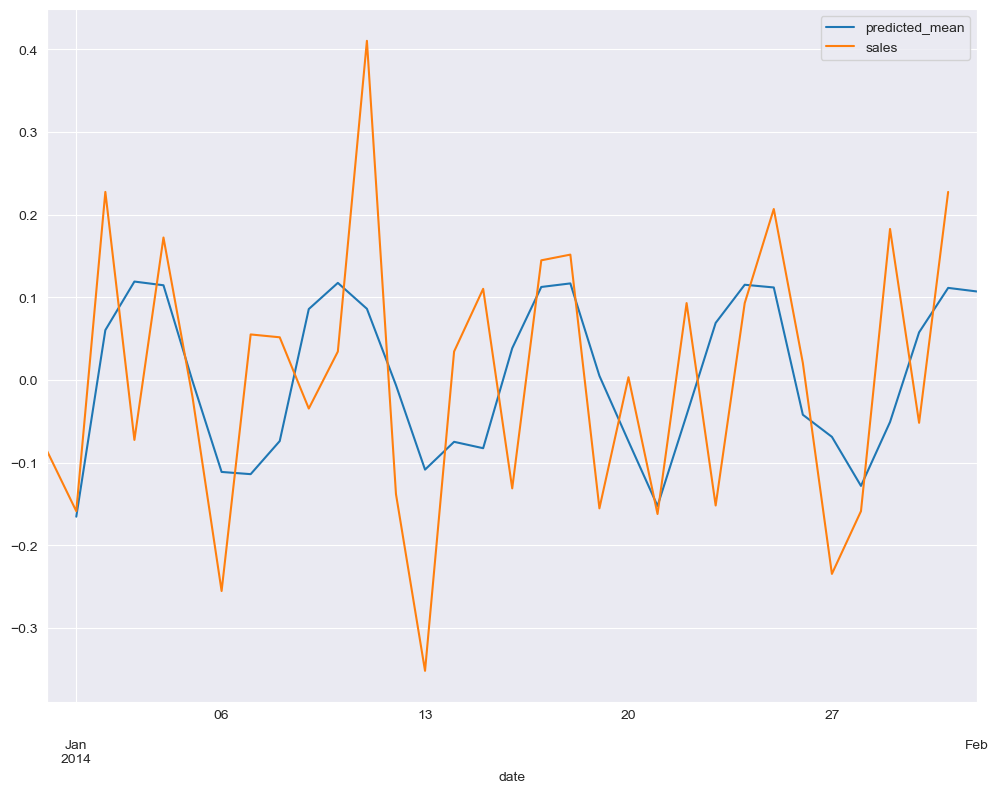

In [190]:
pred.plot(legend=True)
test2.plot(legend=True)

### Forecasting the sales of drinks and food items for the month of february 2014

In [191]:
model3=SARIMAX(y_fast_moving_consumer_goods,order=(2,0,2),seasonal_order=(2,0,2,12))
model3=model3.fit()
y_fast_moving_consumer_goods.tail()

date
2014-02-24   -0.206897
2014-02-25   -0.196552
2014-02-26   -0.034483
2014-02-27    0.003448
2014-02-28    0.141379
Freq: D, Name: sales, dtype: float64

<Axes: >

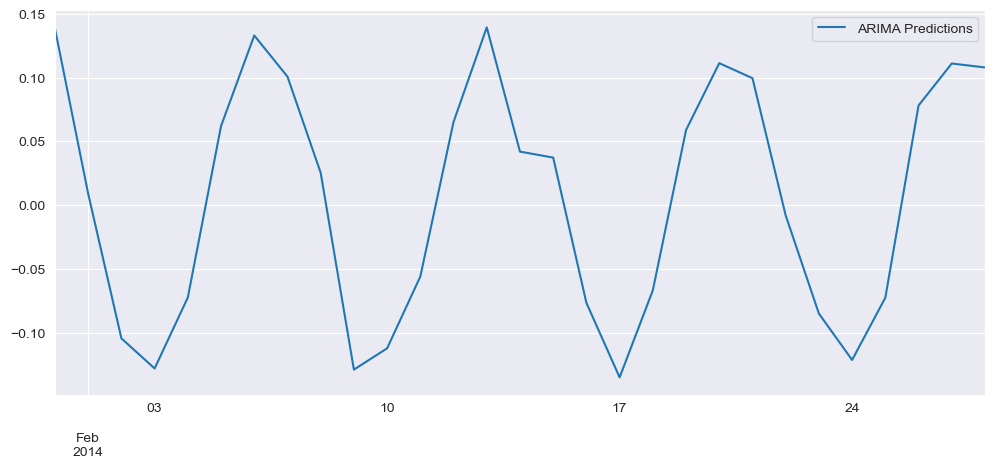

In [192]:
index_future_dates=pd.date_range(start='2014-01-31',end='2014-02-28')
pred=model3.predict(start=len(y_fast_moving_consumer_goods),end=len(y_fast_moving_consumer_goods)+28,type='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
pred.plot(figsize=(12,5),legend=True)

## Other items

### Using Auto ARIMA for choosing best parameters

In [193]:
stepwise_fit = auto_arima(y_other_item, start_p=1, start_q=1,
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=12, max_q=11,  # maximum p and q
                      m=12,              # frequency of series
                      d=None,            # let model determine 'd'
                      seasonal=True,     #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-213.781, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-135.048, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-214.717, Time=1.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-207.787, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1668.924, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-213.296, Time=0.14 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-221.326, Time=5.08 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=7.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=-146.816, Time=4.24 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=-220.229, Time=6.97 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-220.194, Time=6.71 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=-211.701, Time=3.86 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=-218.193, Time=6.98 sec
 ARIMA(1,0,0)(2,0,0)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  790
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                 115.663
Date:                            Fri, 19 May 2023   AIC                           -221.326
Time:                                    21:26:36   BIC                           -197.966
Sample:                                         0   HQIC                          -212.347
                                            - 790                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4711      0.032     14.905      0.000       0.409       0.533
ar.L1          0.3067      0.033      9.224      0.000       0.242       0.372
ar.S.L12       0.0746      0.036      2.089      0.037       0.005       0.145
ar.S.L24      -0.1069      0.034     -3.117      0.002      -0.174      -0.040
sigma2         0.0437      0.002     22.601      0.000       0.040       0.047
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               103.99
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.69
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [194]:
#splitting into test and train
train3 = y_other_item.loc['2012-01-01':'2013-12-31']
test3 = y_other_item.loc['2013-12-31':'2014-01-31']

In [195]:
train3.shape


(731,)

In [196]:
test3.shape


(32,)

In [197]:
train3

date
2012-01-01    0.225
2012-01-02    0.925
2012-01-03    0.325
2012-01-04    0.500
2012-01-05    0.725
              ...  
2013-12-27    0.475
2013-12-28    0.700
2013-12-29    0.550
2013-12-30    0.600
2013-12-31    0.425
Freq: D, Name: sales, Length: 731, dtype: float64

In [198]:
model=SARIMAX(train3,order=(1,0,0),seasonal_order=(2,0,0,12))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  731
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                 -51.797
Date:                            Fri, 19 May 2023   AIC                            111.593
Time:                                    21:26:38   BIC                            129.971
Sample:                                01-01-2012   HQIC                           118.683
                                     - 12-31-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3717      0.037      9.997      0.000       0.299       0.445
ar.S.L12       0.5312      0.035     15.126      0.000       0.462       0.600
ar.S.L24       0.3453      0.037      9.219      0.000       0.272       0.419
sigma2         0.0660      0.003     23.172      0.000       0.060       0.072
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                45.60
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.44
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [199]:
start=len(train3)
end=len(train3)+len(test3)-1
pred=model.predict(start=start,end=end,type='levels')
print(pred)

2014-01-01    0.571866
2014-01-02    0.755875
2014-01-03    0.379102
2014-01-04    0.606323
2014-01-05    0.492899
2014-01-06    0.267423
2014-01-07    0.495956
2014-01-08    0.640753
2014-01-09    0.665339
2014-01-10    0.594294
2014-01-11    0.551800
2014-01-12    0.415676
2014-01-13    0.545487
2014-01-14    0.764088
2014-01-15    0.382663
2014-01-16    0.520632
2014-01-17    0.408586
2014-01-18    0.142061
2014-01-19    0.367048
2014-01-20    0.504393
2014-01-21    0.595143
2014-01-22    0.505609
2014-01-23    0.500300
2014-01-24    0.367563
2014-01-25    0.487232
2014-01-26    0.666893
2014-01-27    0.334177
2014-01-28    0.485926
2014-01-29    0.387241
2014-01-30    0.167803
2014-01-31    0.366231
2014-02-01    0.489187
Freq: D, Name: predicted_mean, dtype: float64


<Axes: xlabel='date'>

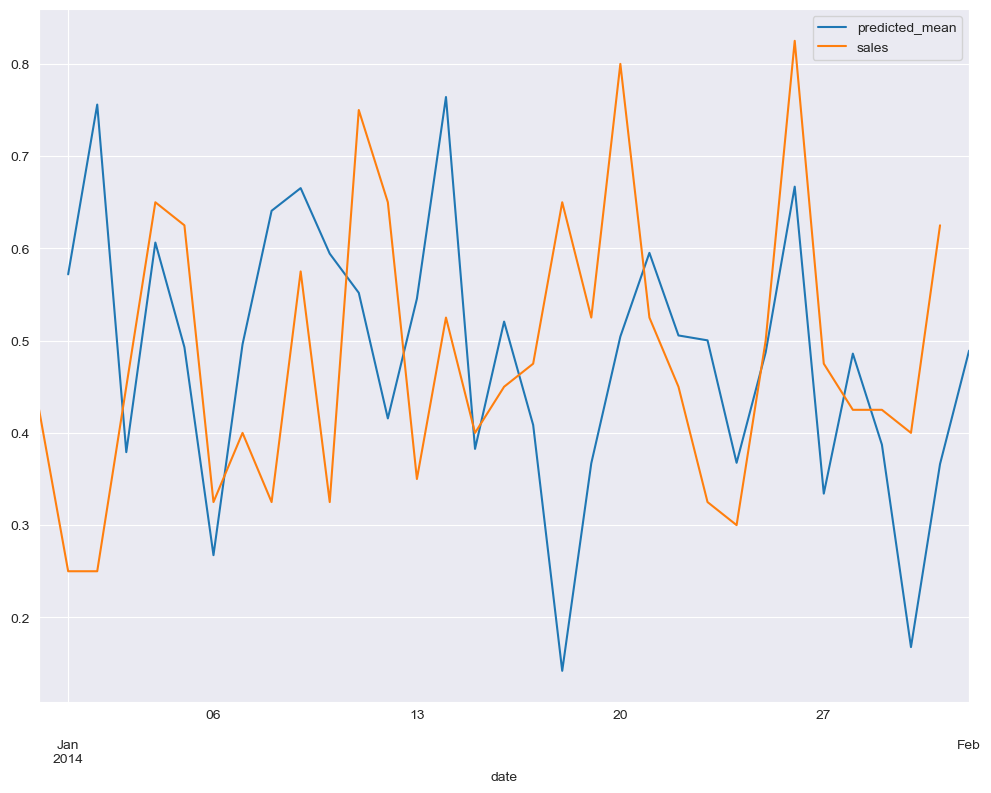

In [200]:
pred.plot(legend=True)
test3.plot(legend=True)

### Forecasting the sales of drinks and food items for the month of february 2014

In [201]:
model4=SARIMAX(y_other_item,order=(1,0,0),seasonal_order=(2,0,0,12))
model4=model4.fit()
y_other_item.tail()

date
2014-02-24    0.275
2014-02-25    0.225
2014-02-26    0.375
2014-02-27    0.400
2014-02-28    0.200
Freq: D, Name: sales, dtype: float64

<Axes: >

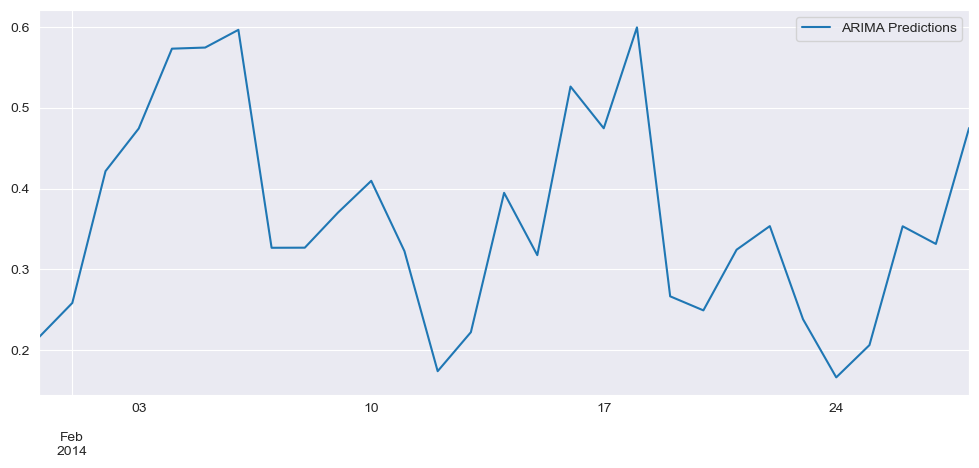

In [202]:
index_future_dates=pd.date_range(start='2014-01-31',end='2014-02-28')
pred=model4.predict(start=len(y_other_item),end=len(y_other_item)+28,type='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
pred.plot(figsize=(12,5),legend=True)